<a href="https://colab.research.google.com/github/scorp08/flight_prices_analysis/blob/main/flight_prices_ML_ozgun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown

import gdown

file_id = "1g-rTLkTFEQ_OjRTY09sc-J0QHAzoffYg"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "route_daily_price_june_2022.csv", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1g-rTLkTFEQ_OjRTY09sc-J0QHAzoffYg
To: /content/route_daily_price_june_2022.csv
100%|██████████| 235k/235k [00:00<00:00, 28.1MB/s]


'route_daily_price_june_2022.csv'

In [ ]:
import pandas as pd

df = pd.read_csv("route_daily_price_june_2022.csv")
df.head()


In [ ]:
total_route = df.groupby("route").aggregate(total_flight_count = ("flight_count", "sum"))
total_route.sort_values("total_flight_count",ascending=False).head(10)


,total_flight_count
route,
LAX-BOS,108702
LGA-LAX,108407
LAX-LGA,103601
ATL-LAX,98812
BOS-LAX,97483
LAX-JFK,93963
LAX-ATL,93490
JFK-LAX,90900
LAX-EWR,89422


In [ ]:
df_model = df[df["route"]=="LAX-BOS"]
df_model.head()

,flightDate,route,avg_total_fare,flight_count
132,2022-06-01,LAX-BOS,480.30713,2818
366,2022-06-02,LAX-BOS,528.20880,2943
600,2022-06-03,LAX-BOS,507.95847,2977
834,2022-06-04,LAX-BOS,512.69180,2955
1068,2022-06-05,LAX-BOS,573.71924,3054


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


In [ ]:
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(f"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(f"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")



In [ ]:
def kpss(data):
  #Kwiatkowski-Phillips-Schmidt-Shin Testi
  #Eğer ADF testi bir birim kök bulamazsa, ancak KPSS testi bulursa, seri fark-durağandır. Yine de fark almanız gerekir.
    kpss_test = sm.tsa.kpss(data)
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Seri Durağandır") if kpss_test[1] > 0.05 else print("Seri durağan değildir(Seri Birim Kök İçerir)")

In [ ]:

def plot_correlations(data,col):
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

  plot_acf(data[col].tolist(), ax=ax1, lags=48)
  plot_pacf(data[col].tolist(), ax=ax2, lags=48, method="ywm")
  plt.show()



In [ ]:
def plot_correlations(data, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5), dpi=70)

    plot_acf(data[col].tolist(), ax=ax1, lags=48)
    plot_pacf(data[col].tolist(), ax=ax2, lags=48, method="ywm")
    plt.show()



In [ ]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)
    if stationary:
      is_stationary(y)
      kpss(y)

In [ ]:
df_model=df_model[["flightDate","avg_total_fare"]]
df_model['flightDate'] = pd.to_datetime(df_model['flightDate'])
df_model = df_model.set_index('flightDate')


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_correlations(data, col):
    n = len(data[col])
    lags = min(14, n // 2)  # güvenli lag sayısı

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5), dpi=70)

    plot_acf(data[col], ax=ax1, lags=lags)
    ax1.set_title("ACF (choose q)")

    plot_pacf(data[col], ax=ax2, lags=lags, method="ywm")
    ax2.set_title("PACF (choose p)")

    plt.show()


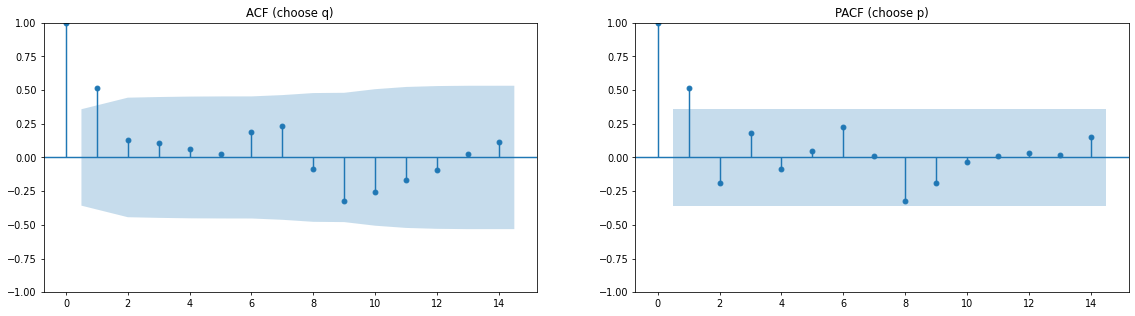

In [ ]:
plot_correlations(df_model, "avg_total_fare")

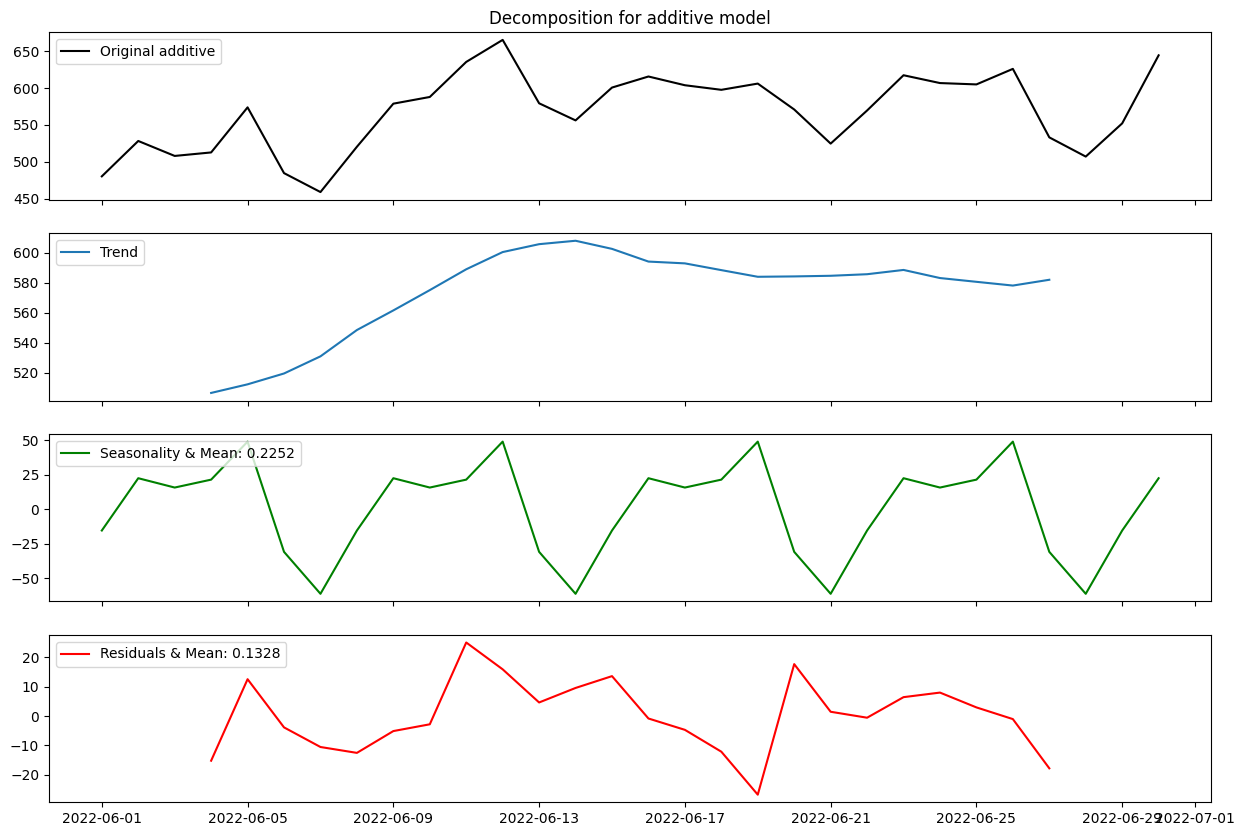

Result: Stationary (H0: non-stationary, p-value: 0.005)


In [ ]:
ts_decompose(df_model,stationary=True)


In [ ]:
import statsmodels.api as sm

In [ ]:
model=sm.tsa.statespace.SARIMAX(df['avg_total_fare'],order=(1, 1, 1),seasonal_order=(1,1,1,7))
results=model.fit()

<Axes: >

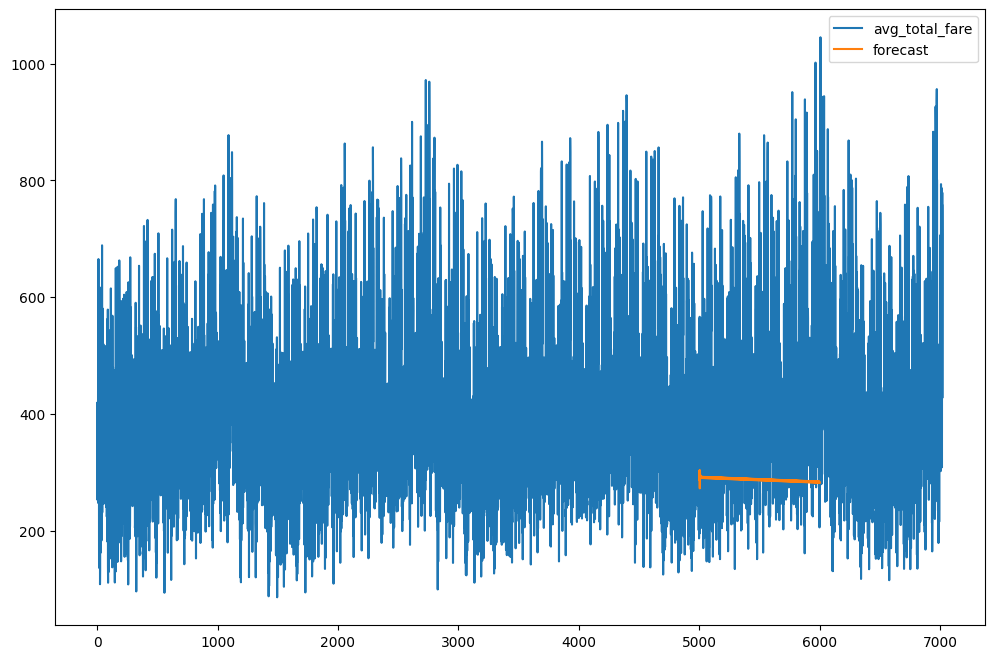

In [ ]:
df['forecast']=results.predict(start=5000,end=6000,dynamic=True)
df[['avg_total_fare','forecast']].plot(figsize=(12,8))

In [4]:

import matplotlib.pyplot as plt

# Zaman serisi
y = df_model['avg_total_fare']

# Train / Test (son 14 gün test)
train = y[:-14]
test = y[-14:]

# SARIMA modeli
model = sm.tsa.statespace.SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=14)
forecast_mean = forecast.predicted_mean

# Grafik
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast")
plt.legend()
plt.title("LAX–BOS Average Fare Forecast")
plt.show()


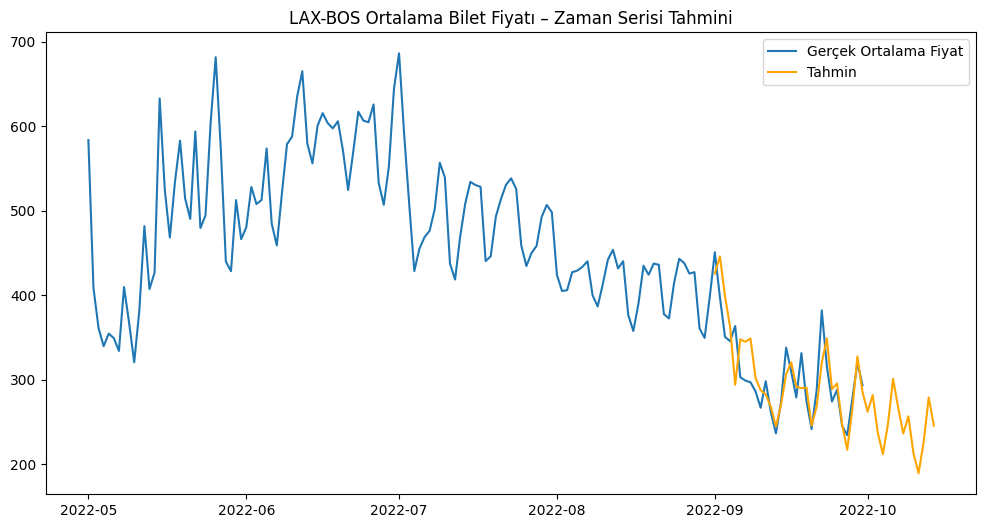

In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import gdown

link="https://drive.google.com/file/d/1F7Z-xURPzvq8tpP36HxsUPhHh3HuGk8C/view?usp=sharing"


file_id = "1F7Z-xURPzvq8tpP36HxsUPhHh3HuGk8C"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "LAX_BOS_MaySep2022.csv", quiet=False)
# 1) CSV oku
df = pd.read_csv("LAX_BOS_MaySep2022.csv")

# 2) Tarih ve route oluştur
df["flightDate"] = pd.to_datetime(df["flightDate"])
df["route"] = df["startingAirport"] + "-" + df["destinationAirport"]

# 3) Route seç (LAX-BOS)
df_model = df[df["route"] == "LAX-BOS"]

# 4) Günlük ortalama fiyat (time series)
ts = (
    df_model
    .groupby("flightDate")["totalFare"]
    .mean()
    .asfreq("D")
)

# 5) SARIMA modeli
model = sm.tsa.statespace.SARIMAX(
    ts,
    order=(1,1,1),
    seasonal_order=(1,1,1,7)
)
results = model.fit(disp=False)

# 6) Tahmin
forecast = results.predict(
    start=ts.index[-30],
    end=ts.index[-1] + pd.Timedelta(days=14)
)

# 7) Grafik
plt.figure(figsize=(12,6))
plt.plot(ts, label="Gerçek Ortalama Fiyat")
plt.plot(forecast, label="Tahmin", color="orange")
plt.legend()
plt.title("LAX-BOS Ortalama Bilet Fiyatı – Zaman Serisi Tahmini")
plt.show()

In [ ]:
ts

,totalFare
flightDate,
2022-05-01,583.660390
2022-05-02,408.563215
2022-05-03,361.285017
2022-05-04,339.755103
2022-05-05,354.658211
...,...
2022-09-26,245.518728
2022-09-27,234.560470
2022-09-28,277.197546


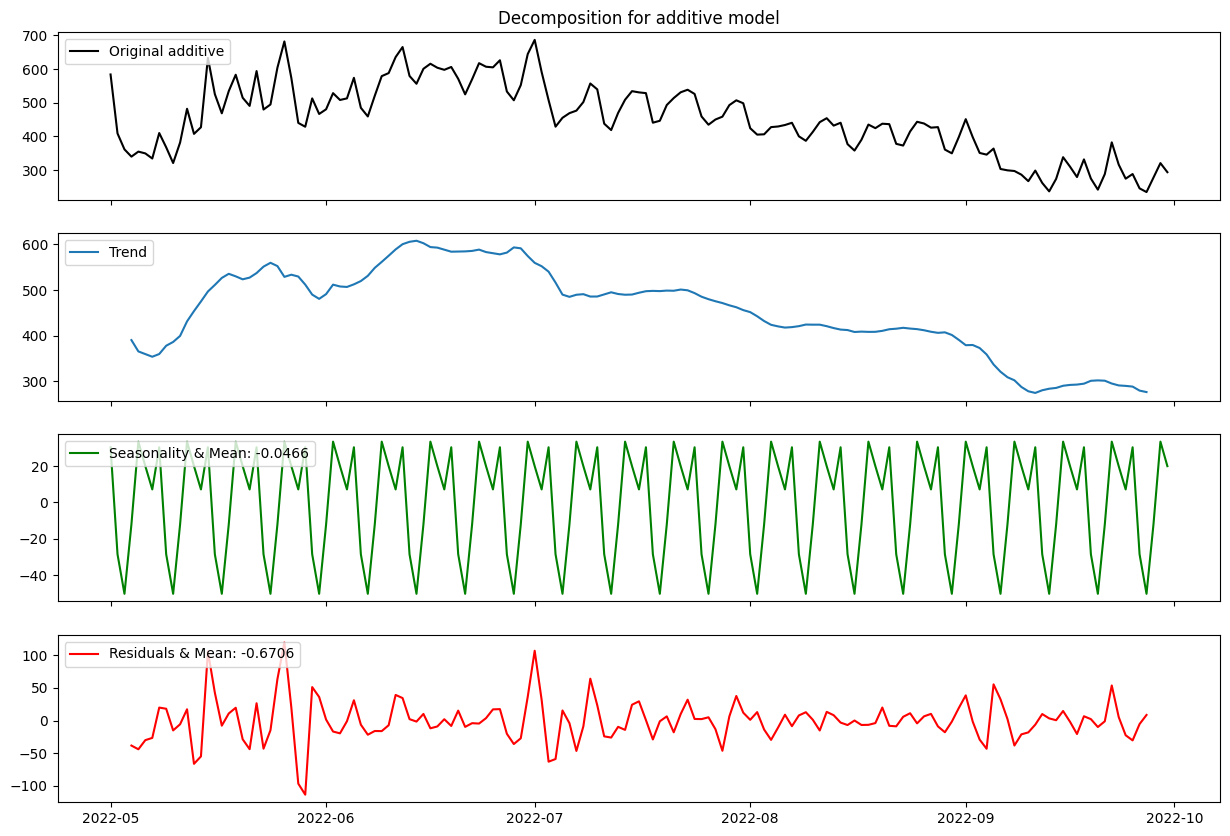

Result: Non-Stationary (H0: non-stationary, p-value: 0.783)
KPSS Statistic: 1.069446
p-value: 0.010000
Seri durağan değildir(Seri Birim Kök İçerir)


/tmp/ipython-input-114629163.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = sm.tsa.kpss(data)


In [ ]:
ts_decompose(ts,stationary=True)

In [7]:
import itertools
p = range(2, 4)
d = [1]
q = range(2, 4)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit(disp=0)
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

The smallest AIC is 1137.7290605754686 for model SARIMAX(2, 1, 3)x(2, 1, 3, 7)


In [13]:
order=SARIMAX_model[AIC.index(min(AIC))][0]
ses_order=SARIMAX_model[AIC.index(min(AIC))][1]

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


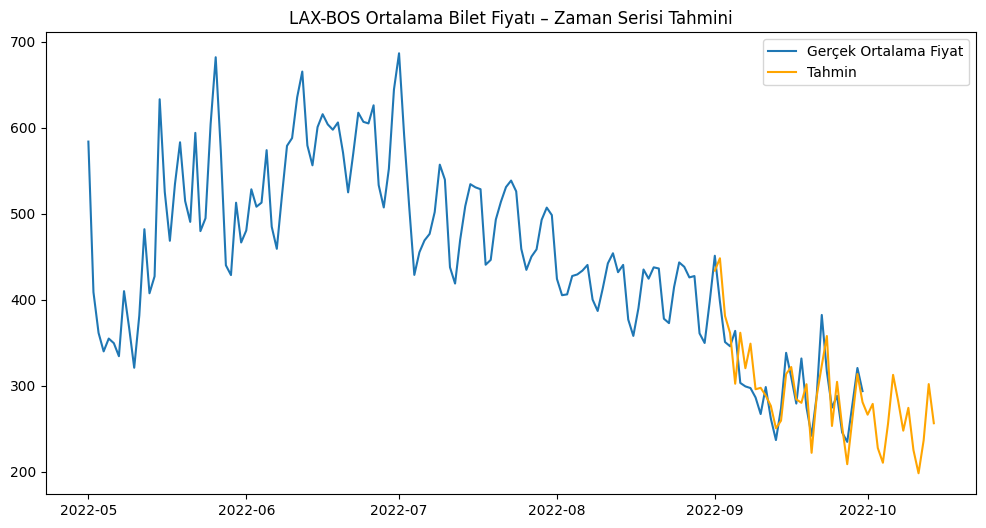

In [19]:
model = sm.tsa.statespace.SARIMAX(
    ts,
    order=order,
    seasonal_order=ses_order
)
results = model.fit(disp=False)

# 6) Tahmin
forecast = results.predict(
    start=ts.index[-30],
    end=ts.index[-1] + pd.Timedelta(days=14)
)

# 7) Grafik
plt.figure(figsize=(12,6))
plt.plot(ts, label="Gerçek Ortalama Fiyat")
plt.plot(forecast, label="Tahmin", color="orange")
plt.legend()
plt.title("LAX-BOS Ortalama Bilet Fiyatı – Zaman Serisi Tahmini")
plt.show()

Timestamp('2022-09-30 00:00:00')